### Описание проекта

Первая и самая важная цель банка — заработать деньги. Если банк будет вести слишком жесткую политику, не выдавая кредиты даже тем, кто вернул бы деньги, то он не заработает на процентах. Отказ в кредите хорошему заемщику — `ошибка первого рода`. Риск, с которым сталкивается кредитная организация — дать кредит неблагонадёжному заёмщику, который впоследствии может допустить дефолт, а банк потеряет деньги — `ошибка второго рода`.    
Для сохранения этого баланса используется кредитный скоринг, который позволяет спрогнозировать вероятность невозврата кредита. Клиентов, обратившихся за кредитом, сортируют по этой предсказанной вероятности (по убыванию), и получается скоркарта — рейтинг клиентов от плохих к хорошим. 

*Используя данные о клиентах банка в имеющемся датасете, попробуем построить такую скоринговую модель.*

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score  

from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.simplefilter('ignore')

#np.set_printoptions(suppress=True)

# settings to display all columns
pd.set_option("display.max_columns", None)

# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

import os
for dirname, _, filenames in os.walk('/kaggle/input\sf-dst-scoring'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input\sf-dst-scoring\sample_submission.csv
/kaggle/input\sf-dst-scoring\test.csv
/kaggle/input\sf-dst-scoring\train.csv


### Загрузка и предварительный осмотр данных

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR+'/train.csv')
test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
# тренировочные данные
print(train.info())
print(f'Размер тренировочного датасета: {train.shape}')
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


In [4]:
# тестовые данные
print(test.info())
print(f'Размер тестового датасета: {test.shape}')
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [5]:
# данные представления 
print(sample_submission.info())
print(f'Size dataset: {sample_submission.shape}')
sample_submission.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
Size dataset: (24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370


In [6]:
# Объединяем тренировочные и тестовые данные в один датасет
train['sample'] = 1 # помечаем тренировочные
test['sample'] = 0 # помечаем тестовые
test['default'] = -1 # 

data = pd.concat([train, test], ignore_index=True)

data.tail(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,-1,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,-1,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,-1,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,-1,0
110147,69044,17MAR2014,SCH,M,38,N,N,0,0,-1.507549,2,50,1,2,15000,4,2,N,-1,0


In [7]:
# данные объединенного датасета
print(data.info())
print(f'Размер объединенного датасета:  {data.shape}')
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1


## Описание полей (вводные переменные)
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

### Предобработка

In [8]:
def missing_value(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также процент пропуска
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

def an_katcol(df, col):
    ''' функция для отображения распределения категриальных переменных '''
    
    print(f'Признак: \033[1m\033[30m{col}')

    fig, axes = plt.subplots(ncols=2)
    sns.countplot(df[col], hue='default', data=df, ax=axes[0])
    axes[0].set_title('График распределения признака')
    sns.barplot(x=col, y='default', data=df, ax=axes[1])
    axes[1].set_title('Влияние признака на дефолт')
    fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
    plt.show()
    
def an_katcol_box(df, col1, col2):
    ''' функция для отображения boxplot категриальных переменных '''
    sns.boxplot(x=col1, y=col2, data=df, showfliers=False)
    plt.show();

### Изучение данных

#### Загрузим данные и проверим:
- Типы данных каждой переменной
- Если у нас пропущенные значения
- Если у нас несбалансированные данные

In [9]:
# Типы данных каждой переменной
pd.DataFrame(data.dtypes, columns=['Тип переменной']).transpose()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
Тип переменной,int64,object,object,object,int64,object,object,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64


#### Есть ли пропуски в данных?

In [10]:
# Если у нас пропущенные значения
missing_value(data,0)

Сумма и процент значений NaN:


,Количество,%
education,478,0.43


Как мы видим, пропуски встречаются в информации об образовании клиентов, чуть позже их заполним.  

Переменная `default` наша целевая переменная для построения модели. Посмотрим на ее распределение по тренировочному датасету:

В нашем примере положительным исходом будет `наличие дефолта` у заемщика, отрицательным — `отсутствие дефолта`.

0    64427
1     9372
Name: default, dtype: int64

Процент заемщиков, не выплативших долг 12.7 %
Процент заемщиков, выплативших долг 87.3 %
Соотношение положительных и отрицательных примеров 14.55 %


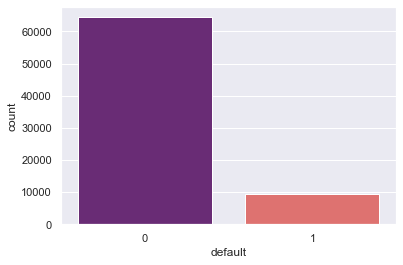

In [11]:
# Если у нас несбалансированные данные
display(train['default'].value_counts())
count_no_def = len(train[train['default'] == 0])
count_def = len(train[train['default'] == 1])
print(
    f'Процент заемщиков, не выплативших долг {round((count_def/(count_def + count_no_def))*100, 2)} %')
print(
    f'Процент заемщиков, выплативших долг {round((count_no_def/(count_def + count_no_def))*100, 2)} %')
print(
    f'Соотношение положительных и отрицательных примеров {round((count_def/count_no_def)*100, 2)} %')
sns.countplot(train['default'], palette='magma')

***Вывод:*** наши классы не сбалансированы, и соотношение выплативших долг к невыплатившим долг заемщикам составляет 87:13.   
К балансировке классов перейдем чуть позже, сначала проведем дополнительное исследование.

In [12]:
round(train.drop(['client_id', 'sample'], 1).groupby('default').mean(), 3)

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
default,,,,,,,,,,,
0,39.391,0.241,0.171,-1.938,1.933,57.169,1.558,2.475,41799.713,1.679,2.806
1,38.525,0.515,0.123,-1.676,2.462,53.678,1.693,2.644,36288.113,2.104,2.486


***Наблюдения:***
- средний возраст заемщиков, выплативших долг, выше, чем у тех кто не выплатил;
- количество отказанных в прошлом заявок в 2 раза больше у заемщиков, не выплативших долг;
- более высокий показатель наличия "хорошей" работы принадлежит заемщикам, выплатившим долг;
- более высокий скоринговый балл по данным из БКИ свидетельствует о "плохих" заемщиках;
- у "хороших" заемщиков рейтинг региона выше;
- более высокие средние показатели категоризаторов домашнего и рабочего адреса в данных принадлежат "плохим" заемщикам";
- не удивительно, что средний показатель дохода у "хорошего" заемщика выше этого показателя у "плохого" заемщика";
- как ни странно, но более высокий средний показатель связи заемщика с другими клиентами банка свидетельствует о "плохом" заемщике;
- у "хороших" заемщиков средний показатель давности наличия информации о нем у банка выше. 

### Анализ, очистка и подготовка данных

In [13]:
print(f'Количество уникальных значений в переменных:')
unic_val, val, idx = [], [], []
for column_name in data.columns:
    unic_val.append(data[column_name].nunique())
    val.append(data[column_name].unique())
    idx.append(column_name)
df = pd.concat([pd.Series(idx), pd.Series(unic_val), pd.Series(val)], axis=1, keys=[
               'Переменная', 'Количество уникальных значений', 'Уникальные значения'])
display(df)

Количество уникальных значений в переменных:


,Переменная,Количество уникальных значений,Уникальные значения
0,client_id,110148,"[25905, 63161, 25887, 16222, 101655, 41415, 28..."
1,app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1..."
2,education,5,"[SCH, GRD, UGR, PGR, ACD, nan]"
3,sex,2,"[M, F]"
4,age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29, 32, 3..."
5,car,2,"[Y, N]"
6,car_type,2,"[Y, N]"
7,decline_app_cnt,24,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9, 13, 11, 19, 10,..."
8,good_work,2,"[0, 1]"
9,score_bki,102618,"[-2.00875292, -1.53227621, -1.40814226, -2.057..."


In [14]:
round(train.drop(['client_id', 'sample'], 1).groupby('education').mean(),2)

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
education,,,,,,,,,,,,
ACD,40.15,0.19,0.47,-2.06,1.87,64.28,1.65,2.61,82966.63,1.51,3.20,0.04
GRD,38.05,0.23,0.25,-1.92,2.15,58.47,1.57,2.49,54663.95,1.57,2.94,0.09
PGR,38.25,0.20,0.30,-1.97,2.18,60.72,1.57,2.49,77548.21,1.45,3.08,0.06
SCH,41.14,0.29,0.11,-1.91,1.96,55.19,1.57,2.49,31960.28,1.83,2.67,0.15
UGR,34.86,0.35,0.17,-1.86,1.78,57.88,1.60,2.54,39391.80,1.78,2.69,0.13


In [15]:
round(train.drop(['client_id', 'sample'], 1).groupby('foreign_passport').mean(),2)

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
foreign_passport,,,,,,,,,,,,
N,39.49,0.28,0.16,-1.90,1.99,55.32,1.57,2.48,36646.24,1.82,2.68,0.14
Y,38.11,0.23,0.21,-1.93,2.04,64.67,1.62,2.56,66346.78,1.27,3.23,0.07


In [16]:
round(train.drop(['client_id', 'sample'], 1).groupby('sex').mean(),2)

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
sex,,,,,,,,,,,,
F,40.66,0.26,0.18,-1.88,2.09,55.49,1.56,2.45,33289.37,1.74,2.75,0.12
M,37.50,0.29,0.15,-1.93,1.89,58.32,1.60,2.55,51169.45,1.73,2.78,0.13


### Обработка колонок с пропусками и датами

Заменим пропуски на самое встречающееся значение в признаке `education`

In [17]:
data['education'].fillna(data['education'].mode()[0], inplace=True)
display(pd.DataFrame(data['education'].value_counts())) 

# проверка
missing_value(data,0)

,education
SCH,58476
GRD,34768
UGR,14748
PGR,1865
ACD,291


NaN значения не найдены.


In [ ]:
# восстанавливаем с помощью класса SimpleImputer из scikit-learn
#from sklearn.impute import SimpleImputer
#imp_mean = SimpleImputer(strategy='most_frequent') 
#imp_mean.fit(data)
#imputed_train_df = imp_mean.transform(data)
#data['education'] = imp_mean.fit_transform(data)[:,2]
#display(pd.DataFrame(data['education'].value_counts()).transpose()) 

# проверка
#missing_value(data,0)

In [18]:
# Переводим дату в нужный вид:
data['app_date'] = pd.to_datetime(data['app_date'])

# Выводим период наблюдений:
display(data['app_date'].max())
display(data['app_date'].min())

Timestamp('2014-04-30 00:00:00')

Timestamp('2014-01-01 00:00:00')

В данных отражен период с января по апрель 2014 года, преобразуем этот признак с данными количества дней между началом периода и датой наблюдения, для снижения размерности цифр для модели возьмем отношение этого признака к количеству дней в периоде

In [19]:
# Кол-во времени между датами
min_date = data['app_date'].min()
data['days'] = data['app_date'].apply(lambda x: (x - min_date).days)
data['days_relative'] = data['days']/120
data.drop(['app_date', 'days'], 1, inplace=True)

### Определение переменных

Для дальнейшего анализа данных разобъем наши признаки на числовые, бинарные и категориальные переменные

In [20]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'days_relative']

### Числовые переменные

Посмотрим на распределение числовых признаков

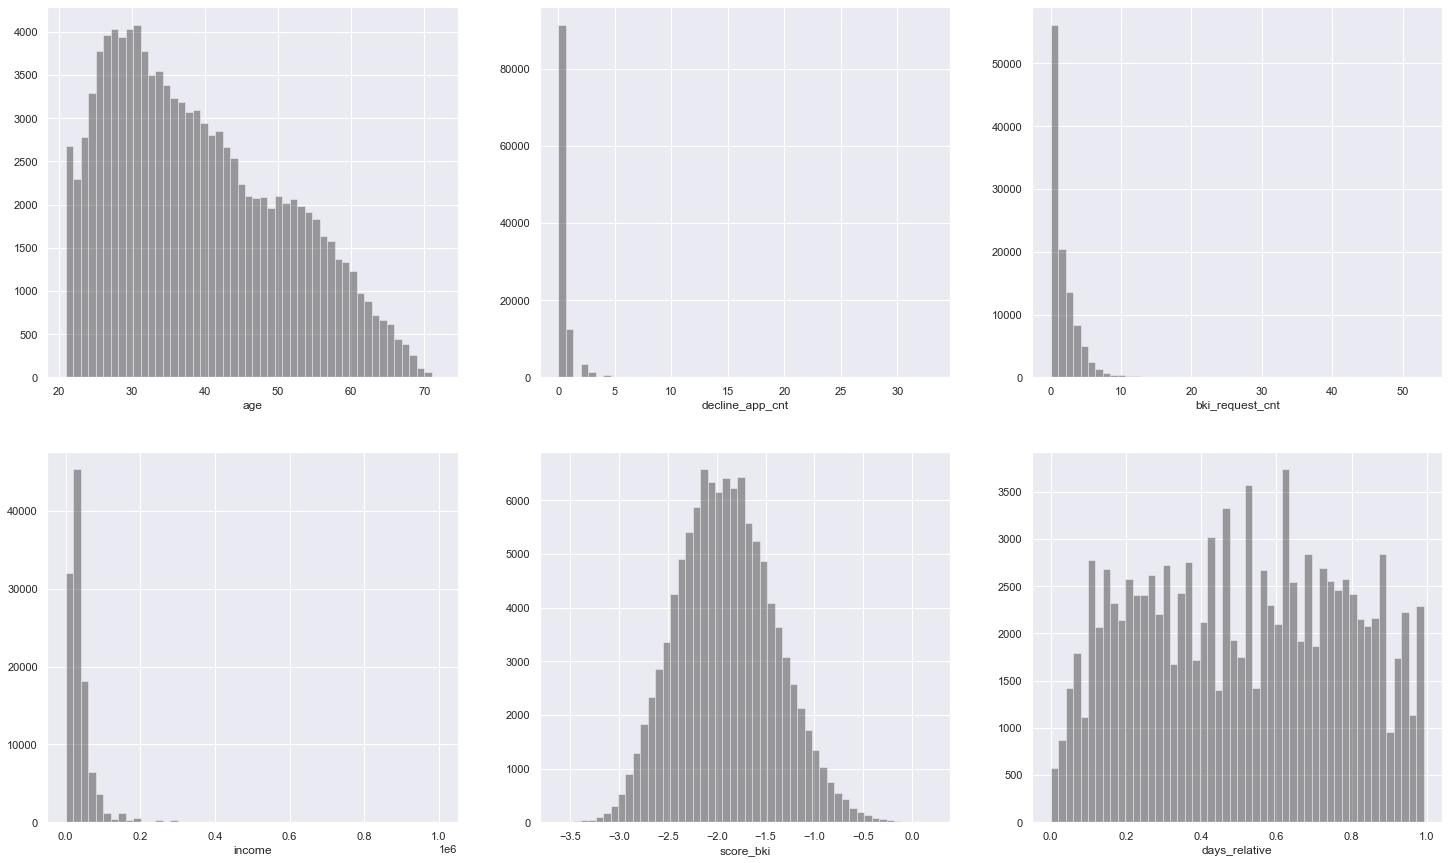

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i], color='k')

Прологарифмируем числовые переменные

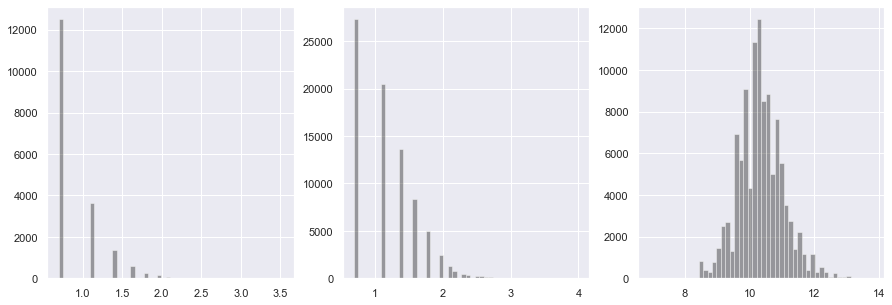

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col+'_log'] = data[col].apply(lambda w: np.log(w + 1))
    sns.distplot(data[[col+'_log']][data[[col+'_log']] > 0],
                 kde=False, ax=axes.flat[i], color='k')

Построим boxplot’ы для численных переменных

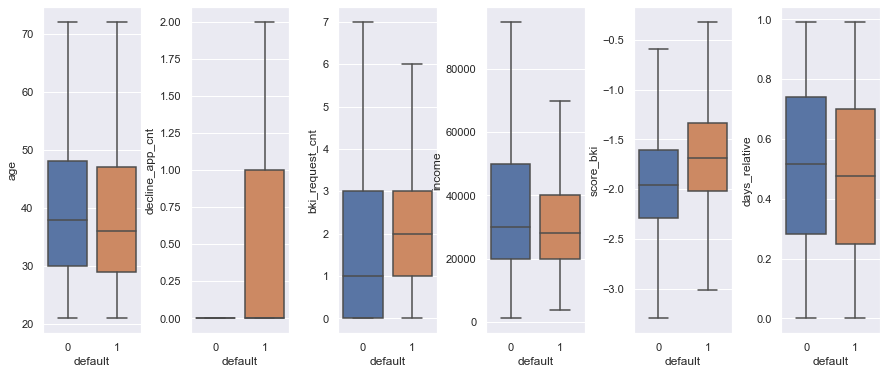

In [23]:
fig, axes = plt.subplots(1, 6, figsize=(15, 6))
plt.subplots_adjust(wspace=0.5)
for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=data[data['sample']
                == 1], orient='v', ax=axes[i], showfliers=False)

***Выводы:***
- дефолтные клиенты в среднем младше;
- дефолтные клиенты в среднем имеют большое количество отказанных заявок;
- дефолтные клиенты в среднем имеют больше запросов в БКИ;
- дефолтные клиенты в среднем имеют более низкий доход;
- дефолтные клиенты в среднем  имеют более высокий скоринговый балл из БКИ
- дефолтные клиенты раньше по дате подали заявки на кредит

### Категориальные переменные

Категориальные переменные у нас в данных 2-х видов: бинарные и ординарные.   
Некоторые бинарные переменные имеют строкое значение, преобразуем их в числа, присвоив им значения 0 или 1.

***Бинарные переменные***

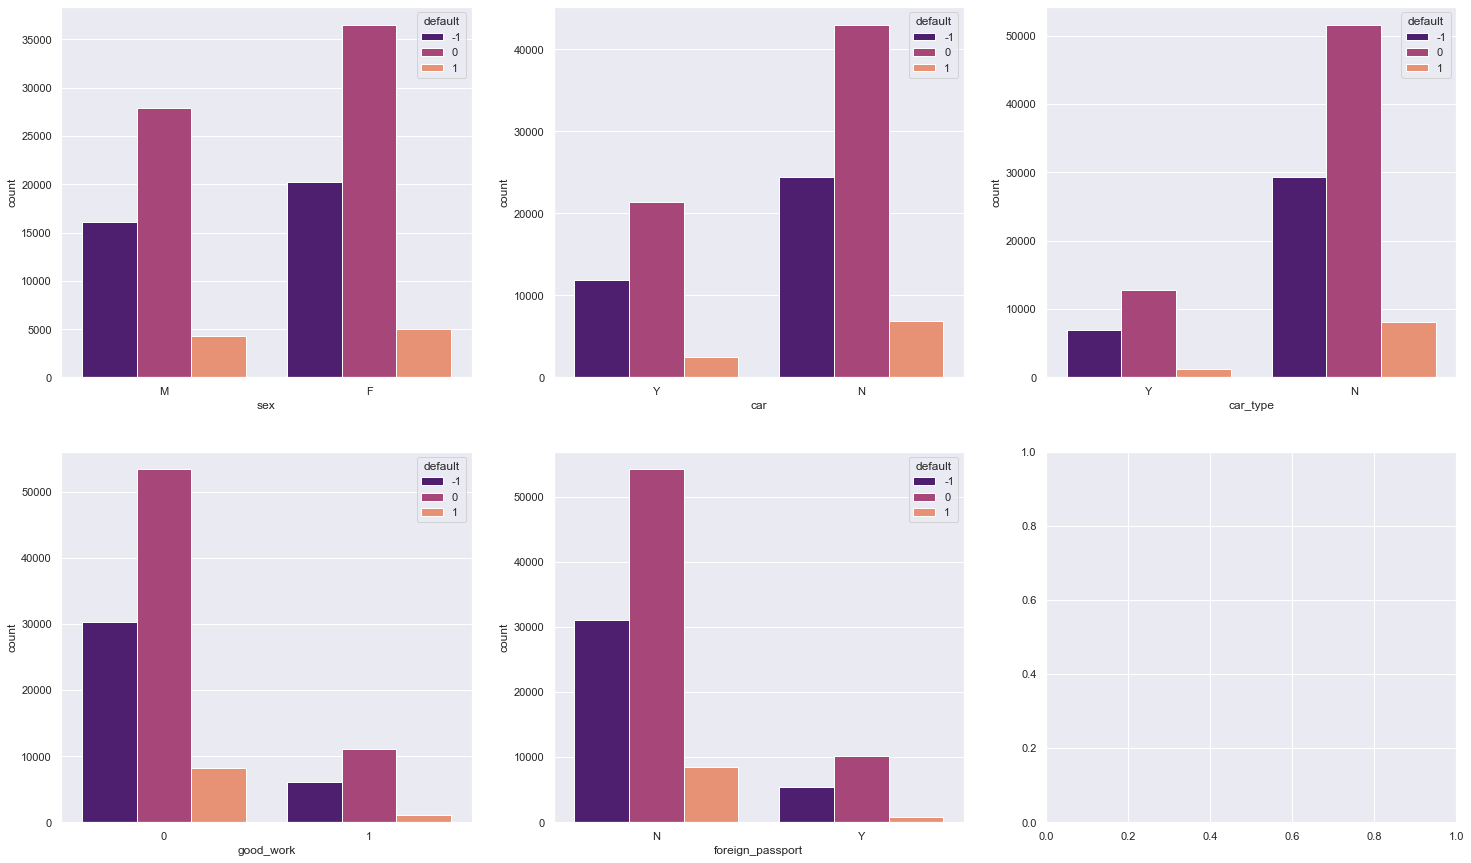

In [24]:
hue = data['default']
data_fig = data[data['sample'] == 1]
fig, axes = plt.subplots(2, 3, figsize=(25, 15))
for i, col in enumerate(bin_cols):
    sns.countplot(x=data[col], hue=hue, data=data_fig,
                  ax=axes.flat[i], palette='magma')

In [25]:
pd.DataFrame(round(data[['sex', 'default']].value_counts(
    normalize=True)*100, 2), columns=['%']).transpose()

sex,F,M,F,M,F,M
default,0,0,-1,-1,1,1
%,33.16,25.33,18.41,14.59,4.57,3.93


In [26]:
pd.concat([pd.DataFrame(round(data[data['sex'] == 'F']['default'].value_counts(\
                                                                    normalize=True)*100, 2)),
          pd.DataFrame(round(data[data['sex'] == 'M']['default'].value_counts(\
                                                                    normalize=True)*100, 2))],\
          axis=1, keys=['F', 'M'])

,F,M
,default,default
0,59.06,57.76
-1,32.79,33.27
1,8.15,8.97


In [27]:
pd.DataFrame(round(data[['car', 'default']].value_counts(
    normalize=True)*100, 2), columns=['%']).transpose()

car          N            Y          N     Y
default      0    -1      0    -1    1     1
%        39.04  22.2  19.45  10.8  6.2  2.31

In [28]:
pd.DataFrame(round(data[['car_type', 'default']].value_counts(
    normalize=True)*100, 2), columns=['%']).transpose()

car_type      N             Y    N     Y      
default       0     -1      0    1    -1     1
%         46.89  26.65  11.61  7.4  6.36  1.11

In [29]:
pd.DataFrame(round(data[['good_work', 'default']].value_counts(
    normalize=True)*100, 2), columns=['%']).transpose()

good_work      0           1     0    1      
default        0    -1     0     1   -1     1
%          48.49  27.5  10.0  7.46  5.5  1.04

In [30]:
pd.DataFrame(round(data[['foreign_passport', 'default']].value_counts(
    normalize=True)*100, 2), columns=['%']).transpose()

foreign_passport      N           Y     N     Y      
default               0     -1    0     1    -1     1
%                 49.19  28.13  9.3  7.76  4.87  0.74

***Выводы:***
- женщины кредитов берут больше, но при этом количество дефолтов между мужчинами и женщинами примерно одинаково
- клиенты, у которых нет машин, берут кредитов больше и невозвратов по кредитам у них также больше
- клиенты с иномарками берут кредиты значительно меньше, и количество дефолтов у них низкое
- клиенты c хорошей работой практически не берут кредиты, и количество дефолтов у них крайне низкое
- клиенты, имеющие загранпаспорта, также мало берут кредитов, и дефолтов у них практически нет

In [31]:
# кодируем признаки
# для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()
label_bin = {}
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    label_bin[column] = dict(enumerate(label_encoder.classes_))
print(label_bin)

# убедимся в преобразовании
data[bin_cols].head()

{'sex': {0: 'F', 1: 'M'}, 'car': {0: 'N', 1: 'Y'}, 'car_type': {0: 'N', 1: 'Y'}, 'good_work': {0: 0, 1: 1}, 'foreign_passport': {0: 'N', 1: 'Y'}}


,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


***Категориальные переменные***

Признак: education


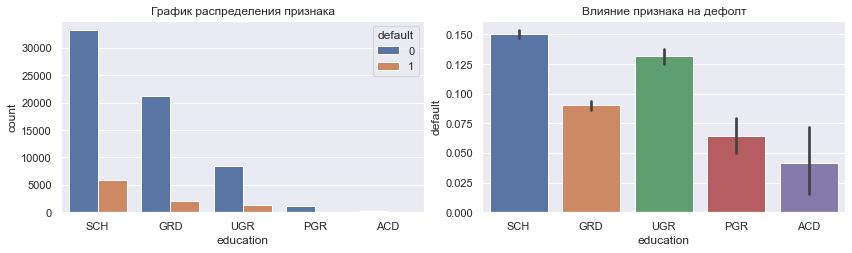

Признак: home_address


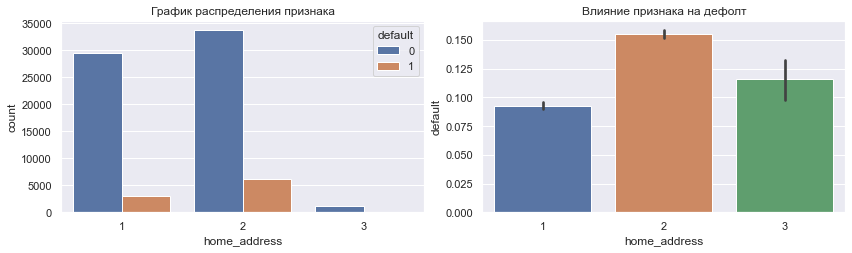

Признак: work_address


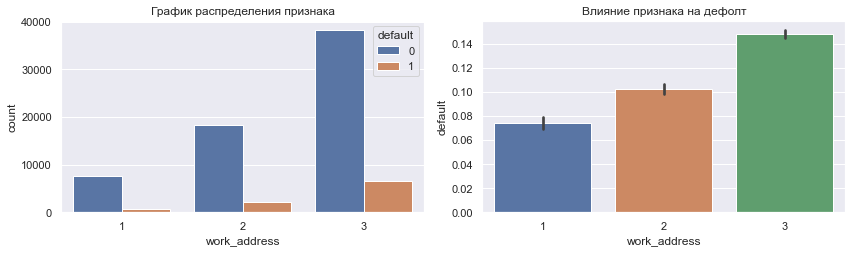

Признак: sna


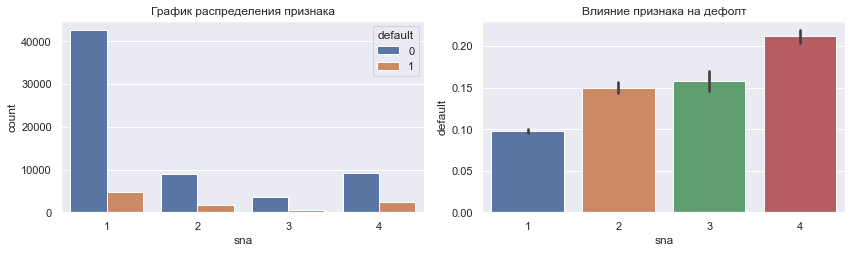

Признак: first_time


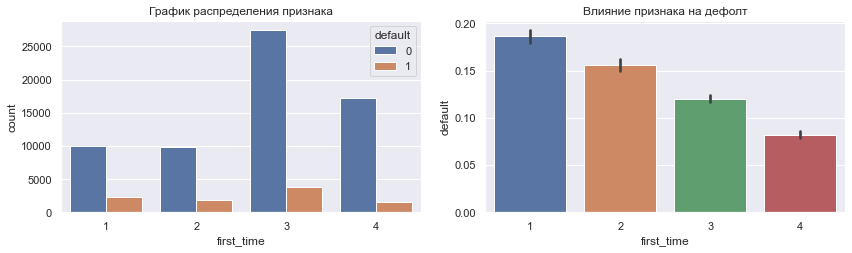

Признак: region_rating


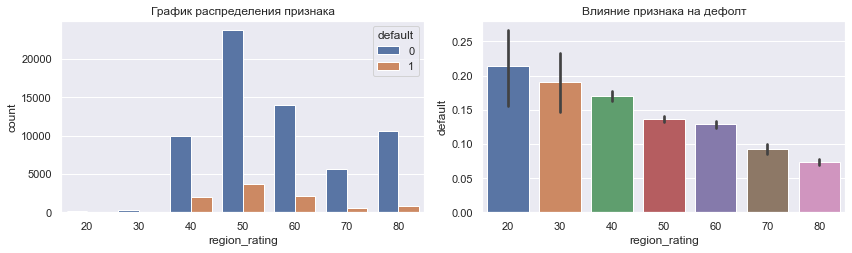

In [32]:
for i in cat_cols:
    an_katcol(data[data['default'] != -1], i)

Построим boxplot’ы для категориальных переменных

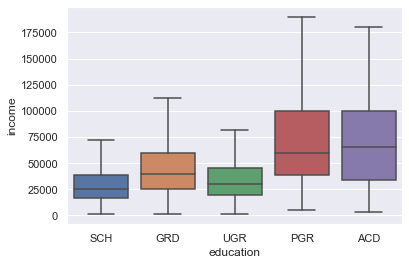

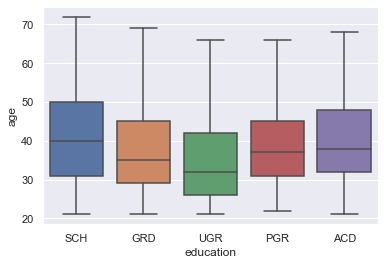

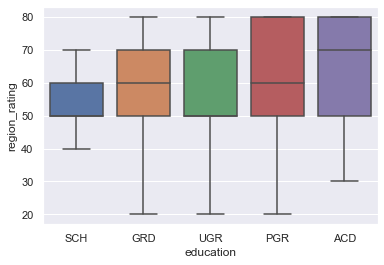

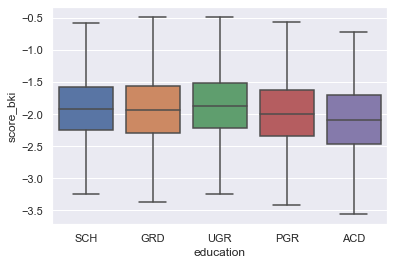

In [33]:
k = ['income', 'age', 'region_rating', 'score_bki']
for i in range(len(k)):
    an_katcol_box(data,'education', k[i])
    

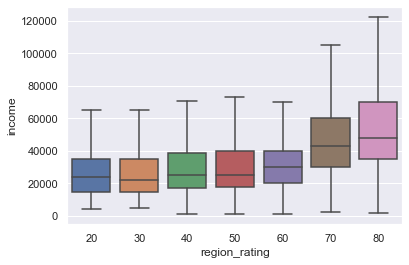

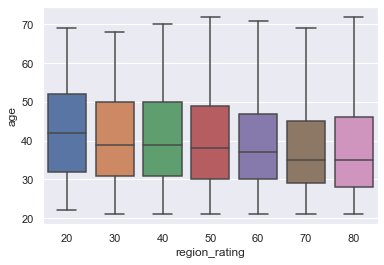

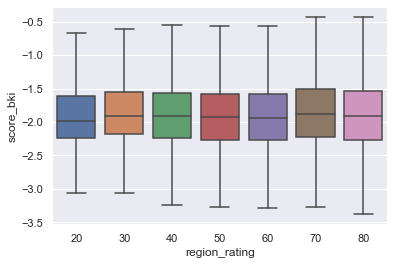

In [34]:
k = ['income', 'age', 'score_bki']
for i in range(len(k)):
    an_katcol_box(data,'region_rating', k[i])

***Выводы:***
- клиенты с высшим образованием берут меньше всего кредитов, у них практически нет дефолтов, они проживает в регионах с высоким рейтингом и имеют высокие доходы
- признаки `home_adress` и  `work_adress` примерно одинаково влияют на наступление дефолта
- наступление дефолта зависит от связи заемщика с клиентами банка как и давность наличия информации о нем
- в регионах с высоким рейтингом берут меньше кредитов, количество дефолтов в этих регионах также ниже чем в остальных

In [35]:
print(list(cat_cols))
for col in cat_cols:
    print(data[col].unique())

['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
[1 2 3]
[2 3 1]
[4 1 2 3]
[1 4 3 2]
[50 80 60 40 70 20 30]


In [36]:
# Перекодируем категориальные признаки с помощью LabelEncoder

label_cat = {}
for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])
    label_cat[column] = dict(enumerate(label_encoder.classes_))
print(label_cat)

# убедимся в преобразовании
data[cat_cols].head()

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}, 'home_address': {0: 1, 1: 2, 2: 3}, 'work_address': {0: 1, 1: 2, 2: 3}, 'sna': {0: 1, 1: 2, 2: 3, 3: 4}, 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}, 'region_rating': {0: 20, 1: 30, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80}}


,education,home_address,work_address,sna,first_time,region_rating
0,3,0,1,3,0,3
1,3,1,2,3,0,3
2,3,0,1,0,3,6
3,3,1,2,0,2,3
4,1,1,2,0,3,4


### Корреляционный анализ

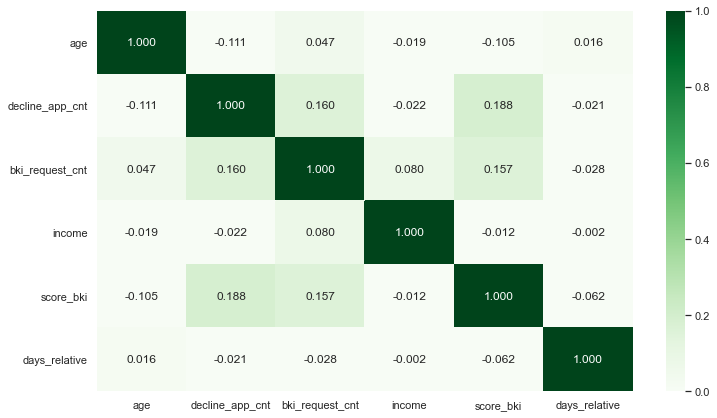

In [37]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(data[num_cols].corr(), vmin=0, vmax=1,
            annot=True, fmt='.3f', cmap='Greens')

***Вывод:*** в целом линейные зависимости между числовыми переменными слабые.   
Все признаки слабо скоррелированы друг с другом, все можно оставить

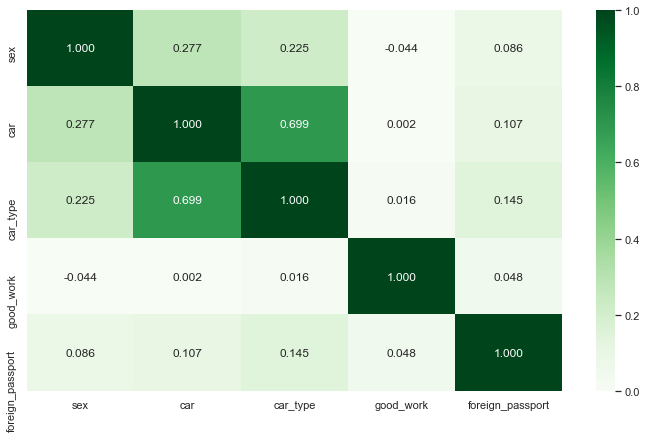

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(data[bin_cols].corr(), vmin=0, vmax=1,
            annot=True, fmt='.3f', cmap='Greens')

***Вывод:*** среди бинарных переменных признаки `car` и `car_type` скоррелированы

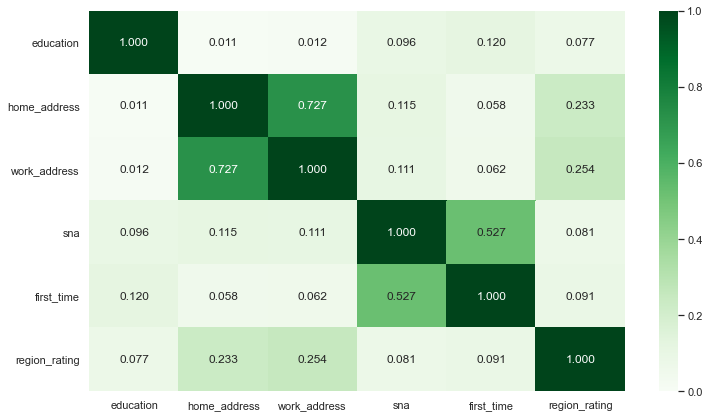

In [39]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(data[cat_cols].corr().abs(), vmin=0, vmax=1,
            annot=True, fmt='.3f', cmap='Greens')

***Вывод:*** среди категориальных переменных признаки `work_address` и `home_address`, а также `sna` и `first_time` скоррелированы

### Создание признаков 

Объединим 2 признака `car` и `car_type` в один    
У нового признака сделаем значения: 0 - нет машины, 1 - есть отечественный автомобиль, 2 - наличие иномарки
и переведем его из бинарного признака в категориальный, сделаем кодирование

In [40]:
data['car_comb'] = data['car'] + data['car_type']
data['car_comb'] = data['car_comb'].astype('category')

data.drop(['car', 'car_type'], 1, inplace=True)
bin_cols.remove('car_type')
bin_cols.remove('car')
cat_cols.append('car_comb')

print(data['car_comb'].unique())

data['car_comb'] = label_encoder.fit_transform(data['car_comb'])
data[cat_cols].head()

[2, 0, 1]
Categories (3, int64): [2, 0, 1]


,education,home_address,work_address,sna,first_time,region_rating,car_comb
0,3,0,1,3,0,3,2
1,3,1,2,3,0,3,0
2,3,0,1,0,3,6,1
3,3,1,2,0,2,3,0
4,1,1,2,0,3,4,0


Объединим 2 признака `work_address` и `home_address` в один - отказалась от объединения

In [ ]:
# возьмем два столбца 'work_address', 'home_address'
# data_addresses = data[['work_address', 'home_address']].values

# создадим Scaler, переведя в непрерывные переменные
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data_addresses)

# С помощью метода главных компонент сократим 2 признака до одного, оставив наиболее значимую информацию
#pca = PCA(n_components=1)
#pca.fit(scaled_data)
#pca_data = pca.transform(scaled_data)
#data['pca_address'] = pca_data
#sns.distplot(data['pca_address'], kde=False, color='k');

# удалим ненужные столбцы
#data.drop(['home_address','work_address'], axis=1, inplace=True)

#data['address'] = data['pca_address'] - data['pca_address'].min() + 1
#sns.distplot(data['address'], color='k');

#data.drop('pca_address', 1, inplace=True)
#cat_cols.remove('home_address')
#cat_cols.remove('work_address')
#num_cols.append('address')
#data['address'].unique()

In [41]:
# добавим признак о среднем доходе для каждого возраста
mean_inc_age = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_inc_age)
# максимальный доход для конкретного возраста
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income)
# нормализуем доход
data['normal_income'] = abs(
    (data['income'] - data['mean_income_age'])/data['max_income_age'])
#data['normal_income1'] = (data['income'] - data['mean_income_age'])/data['std_income_age']
data.drop(['mean_income_age', 'max_income_age'],  axis=1, inplace=True)

# добавим признак о среднем количестве отказанных заявок по возрастам
mean_dec_age = data.groupby('age')['decline_app_cnt'].mean().to_dict()
data['mean_decline_age'] = data['age'].map(mean_dec_age)
# максимальный количество отказов заявок для конкретного возраста
max_decline = data.groupby('age')['decline_app_cnt'].max().to_dict()
data['max_decline_age'] = data['age'].map(max_decline)
# нормализуем количество отказов заявок
data['normal_decline'] = abs(
    (data['decline_app_cnt'] - data['mean_decline_age'])/data['max_decline_age'])
#data['normal_decline1'] = (data['decline_app_cnt'] - data['mean_decline_age'])/data['std_decline_age']
data['normal_decline'].fillna(data['normal_decline'].median(), inplace=True)

# добавим признак о среднем количестве запросов в БКИ
mean_bki_age = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_bki_age'] = data['age'].map(mean_bki_age)
# максимальный количество запросов в БКИ для конкретного возраста
max_bki = data.groupby('age')['bki_request_cnt'].max().to_dict()
data['max_bki_age'] = data['age'].map(max_bki)
# нормализуем количество запросов в БКИ
data['normal_bki'] = abs(
    (data['bki_request_cnt'] - data['mean_bki_age'])/data['max_bki_age'])
#data['normal_bki1'] = (data['bki_request_cnt'] - data['mean_bki_age'])/data['std_bki_age']
data['normal_bki'].fillna(data['normal_bki'].median(), inplace=True)
data.drop(['mean_decline_age', 'max_decline_age', 'mean_decline_age',
          'max_decline_age', 'mean_bki_age', 'max_bki_age'],  axis=1, inplace=True)

Посмотрим на распределение новых признаков

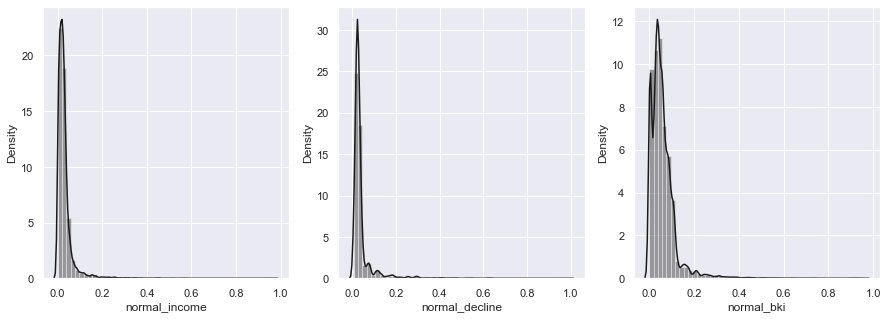

In [42]:
num_cols_new = ['normal_income', 'normal_decline', 'normal_bki']
for i in num_cols_new:
    num_cols.append(i)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(num_cols_new):
    sns.distplot(data[col], ax=axes.flat[i], color='k')

***Признак `age`:***переведем в категориальный, разбив его на 5 возрастных диапозонов по 10 лет - отказалась от преобразования

In [ ]:
#median = data['age'].median()
#perc25 = data['age'].quantile(0.25)
#perc75 = data['age'].quantile(0.75)
#print(f'median= {median}, perc25= {perc25}, perc75= {perc75}')
#data['age_cat'] = data['age'].apply(lambda x:0 if x<=perc25 else 1 if perc25<x<=median else 2 if median<x<=perc75 else 3)
#data.drop('age', axis=1, inplace=True)
# num_cols.remove('age')
# cat_cols.append('age_cat')
# data['age_cat'].unique()

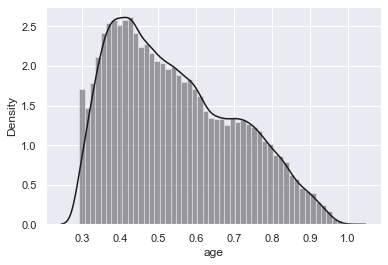

In [43]:
max_age = data['age'].max()
data['age'] = data['age']/max_age
sns.distplot(data['age'], color='k');

***Признак `decline_app_cnt`:*** по графикам видно, что большее число отказанных в прошлом заявок было не больше 5. Поэтому переведем данный признак в категориальный, у которого число отказанных заявок начиная с 5 будет обозначено цифрой 5 - отказалась от преобразования

In [ ]:
#data['decline_app_cnt_cat'] = data['decline_app_cnt'].apply(lambda x:x if x <= 4 else 5)
#data.drop(['decline_app_cnt','mean_decline_age', 'max_decline_age'],  axis = 1, inplace = True)
#data.drop('decline_app_cnt', axis=1, inplace=True)
# num_cols.remove('decline_app_cnt')
# cat_cols.append('decline_app_cnt_cat')
# data['decline_app_cnt_cat'].unique()

***Признак `bki_request_cnt`:*** по графикам видно, что основное количество запросов в БКИ не превышает 10. Поэтому переведем данный признак в категориальный, у которого количество запросов в БКИ начиная с 6 будет обозначено цифрой 6. - отказалась от преобразования

In [ ]:
#data['bki_request_cnt_cat'] = data['bki_request_cnt'].apply(lambda x:x if x <= 5 else 6)
#data.drop(['bki_request_cnt'],  axis = 1, inplace = True)
# num_cols.remove('bki_request_cnt')
# cat_cols.append('bki_request_cnt_cat')
# data['bki_request_cnt_cat'].unique()

In [44]:
data.drop(['income', 'decline_app_cnt', 'bki_request_cnt'], 1, inplace=True)

In [45]:
num_cols.remove('income')
num_cols.append('income_log')
num_cols.remove('decline_app_cnt')
num_cols.append('decline_app_cnt_log')
num_cols.remove('bki_request_cnt')
num_cols.append('bki_request_cnt_log')

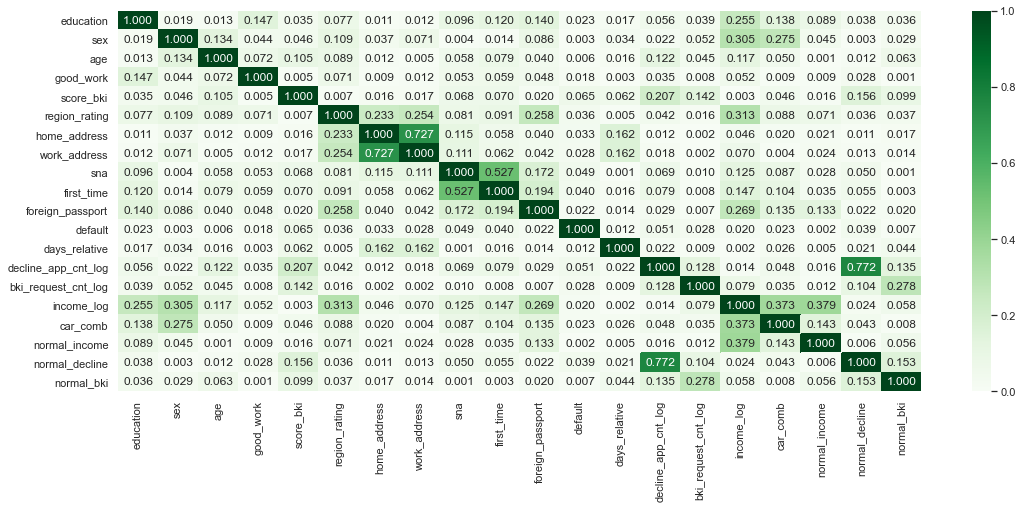

In [46]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.heatmap(data.drop(['client_id', 'sample'], 1).corr().abs(
), vmin=0, vmax=1, annot=True, fmt='.3f', cmap='Greens')

In [47]:
data.drop(['normal_decline'], 1, inplace=True)
num_cols.remove('normal_decline')

### Значимость числовых переменных

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

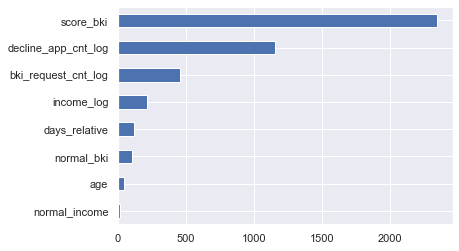

In [48]:
df = data[data['sample'] == 1]
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [49]:
f_classif(df[num_cols], df['default'])

(array([  46.16616807, 2341.59944974,  114.57682408,   16.49845391,
         102.72776512,  214.7905274 , 1152.93731744,  457.59176046]),
 array([1.09457597e-011, 0.00000000e+000, 1.01922301e-026, 4.87400109e-005,
        3.98775418e-024, 1.44923016e-048, 8.96214000e-251, 3.26668128e-101]))

In [ ]:
#data.drop('normal_income', 1, inplace=True)
#num_cols.remove('normal_income')

***Вывод:*** из числовых переменных самый значимый признак - `score_bki`, самый незначимый - `normal_income`.

### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных и бинарных переменных будем использовать функцию `mutual_info_classif` из библиотеки `sklearn`. 

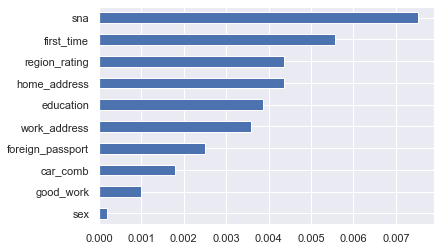

In [50]:
df = data[data['sample'] == 1]
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [51]:
f_classif(df[bin_cols + cat_cols], df['default'])

(array([  28.41465738,  139.01130278,  329.96184694,  379.82856704,
         532.44981036,  494.46026035, 1187.28103754,  831.87680998,
         589.67838101,  214.9439637 ]),
 array([9.82078995e-008, 4.67979108e-032, 1.41830731e-073, 2.21273381e-084,
        2.16096850e-117, 3.49040371e-109, 4.02629037e-258, 6.52547925e-182,
        9.53819661e-130, 1.34203122e-048]))

***Вывод:*** из категориальных переменных самый значимый признак - `sna`, самый незначимый - `sex`.        

Преобразуем категориальные переменные в dummies-переменные

In [52]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols) 

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   sex                  110148 non-null  int32  
 2   age                  110148 non-null  float64
 3   good_work            110148 non-null  int64  
 4   score_bki            110148 non-null  float64
 5   foreign_passport     110148 non-null  int32  
 6   default              110148 non-null  int64  
 7   sample               110148 non-null  int64  
 8   days_relative        110148 non-null  float64
 9   decline_app_cnt_log  110148 non-null  float64
 10  bki_request_cnt_log  110148 non-null  float64
 11  income_log           110148 non-null  float64
 12  normal_income        110148 non-null  float64
 13  normal_bki           110148 non-null  float64
 14  education_0          110148 non-null  uint8  
 15  education_1      

In [55]:
data.columns[14:43]

Index(['education_0', 'education_1', 'education_2', 'education_3',
       'education_4', 'home_address_0', 'home_address_1', 'home_address_2',
       'work_address_0', 'work_address_1', 'work_address_2', 'sna_0', 'sna_1',
       'sna_2', 'sna_3', 'first_time_0', 'first_time_1', 'first_time_2',
       'first_time_3', 'region_rating_0', 'region_rating_1', 'region_rating_2',
       'region_rating_3', 'region_rating_4', 'region_rating_5',
       'region_rating_6', 'car_comb_0', 'car_comb_1', 'car_comb_2'],
      dtype='object')

In [56]:
cat_cols_new = list(data.columns[14:43])
len(data.columns[14:43])

29

#### Обновим списки переменных:

In [57]:
# числовые переменные, уберем из них переменные переведенные в разряд категориальных
print(f'числовые переменные: {num_cols}\n')

# бинарные переменные, добавим к ним признак наличия пропусков в данных
print(f'бинарные переменные: {bin_cols}\n')

# категориальные переменные, добавим к ним переменные, переведенные из числовых
print(f'категориальные переменные: {cat_cols_new}')

числовые переменные: ['age', 'score_bki', 'days_relative', 'normal_income', 'normal_bki', 'income_log', 'decline_app_cnt_log', 'bki_request_cnt_log']

бинарные переменные: ['sex', 'good_work', 'foreign_passport']

категориальные переменные: ['education_0', 'education_1', 'education_2', 'education_3', 'education_4', 'home_address_0', 'home_address_1', 'home_address_2', 'work_address_0', 'work_address_1', 'work_address_2', 'sna_0', 'sna_1', 'sna_2', 'sna_3', 'first_time_0', 'first_time_1', 'first_time_2', 'first_time_3', 'region_rating_0', 'region_rating_1', 'region_rating_2', 'region_rating_3', 'region_rating_4', 'region_rating_5', 'region_rating_6', 'car_comb_0', 'car_comb_1', 'car_comb_2']


In [58]:
data

,client_id,sex,age,good_work,score_bki,foreign_passport,default,sample,days_relative,decline_app_cnt_log,bki_request_cnt_log,income_log,normal_income,normal_bki,education_0,education_1,education_2,education_3,education_4,home_address_0,home_address_1,home_address_2,work_address_0,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6,car_comb_0,car_comb_1,car_comb_2
0,25905,1,0.861111,0,-2.008753,0,0,1,0.258333,0.000000,0.693147,9.798183,0.033418,0.044363,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1,63161,0,0.819444,0,-1.532276,0,0,1,0.583333,0.000000,1.386294,9.852247,0.011368,0.037015,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,25887,1,0.347222,0,-1.408142,1,0,1,0.258333,1.098612,0.693147,10.308986,0.009755,0.028326,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,16222,0,0.736111,0,-2.057471,0,0,1,0.183333,0.000000,1.098612,9.210440,0.032983,0.007851,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,101655,1,0.666667,1,-1.244723,1,0,1,0.891667,0.000000,0.693147,10.308986,0.017945,0.033789,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0,0.513889,0,-1.744976,0,-1,0,0.741667,0.693147,1.386294,9.615872,0.047464,0.033083,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
110144,106254,0,0.888889,0,-2.293781,0,-1,0,0.950000,0.000000,1.386294,12.206078,0.267657,0.039558,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
110145,81852,1,0.430556,0,-0.940752,0,-1,0,0.733333,1.098612,0.693147,11.002117,0.018050,0.031480,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0
110146,1971,0,0.375000,0,-1.242392,0,-1,0,0.050000,0.693147,1.098612,10.308986,0.010263,0.002923,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


### Построение модели

##### Подготовка данных и обучение модели

In [59]:
# Делим датасет на тест и трейн:

train_df = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_df = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

train_df.shape, test_df.shape

((73799, 41), (36349, 41))

#### Выбросы и стандартизация числовых переменных

In [60]:
for col in num_cols:
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25

    print("Column: ", col)
    print(
        f'25%: {perc25}, 75%: {perc75}, IQR: {IQR}, \
        Borderline: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}]')
    print(
        f'min: {data[col].min()}, median: {data[col].median()}, \
        max: {data[col].max()}')
    print()

Column:  age
25%: 0.4166666666666667, 75%: 0.6666666666666666, IQR: 0.24999999999999994, Borderline: [0.041666666666666796, 1.0416666666666665]
min: 0.2916666666666667, median: 0.5138888888888888, max: 1.0

Column:  score_bki
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004, Borderline: [-3.299251946250001, -0.5290698762499992]
min: -3.62458632, median: -1.92082293, max: 0.19977285

Column:  days_relative
25%: 0.275, 75%: 0.7416666666666667, IQR: 0.4666666666666667, Borderline: [-0.42499999999999993, 1.4416666666666667]
min: 0.0, median: 0.5166666666666667, max: 0.9916666666666667

Column:  normal_income
25%: 0.01180008343659645, 75%: 0.03442684580865195, IQR: 0.0226267623720555, Borderline: [-0.022140060121486803, 0.0683669893667352]
min: 1.9874312647229282e-07, median: 0.022073296512657107, max: 0.9737102022653722

Column:  normal_bki
25%: 0.02791508238276299, 75%: 0.07704498354260636, IQR: 0.04912990115984337, Borderline: [-0.04577976935700207, 0.150739835282371

В целом выбросы в числовых переменных незначительны, будем стандартизировать их с помощью StandardScaler

In [61]:
# Стандартизация числовых переменных
scaler = StandardScaler()
X_num = scaler.fit_transform(train_df[num_cols].values)
X_num_test = scaler.transform(test_df[num_cols].values)

In [ ]:
# Стандартизация числовых переменных
#scaler = RobustScaler()
#X_num = scaler.fit_transform(train_df[num_cols].values)
#X_num_test = scaler.transform(test_df[num_cols].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в `одно признаковое пространство`, разделив при этом признаки и целевую переменную.

In [62]:
# Объединяем числовые, бинарные и категориальные переменные в одно признаковое пространство,
# разделив при этом признаки и целевую переменную:

X = np.hstack([X_num, train_df[bin_cols].values,
              train_df[cat_cols_new].values])
Y = train_df['default'].values

X_test_data = np.hstack(
    [X_num_test, test_df[bin_cols].values, test_df[cat_cols_new].values])
Y_test_data = test_df['default'].values

In [63]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=RANDOM_SEED)
print(X.shape, X_train.shape, X_test.shape,
      Y.shape, y_train.shape, y_test.shape)

(73799, 40) (59039, 40) (14760, 40) (73799,) (59039,) (14760,)


→ Подготовка признаков для модели завершена.

### Моделирование и оценка качества модели

#### Модель версия 0. Базовая

*Обучим модель на стандартных настройках логистической регрессии (базовая модель)*

In [64]:
model_0 = LogisticRegression(
    class_weight='balanced', max_iter=2000, random_state=RANDOM_SEED)
model_0.fit(X_train, y_train)
y_pred_0 = model_0.predict(X_test)

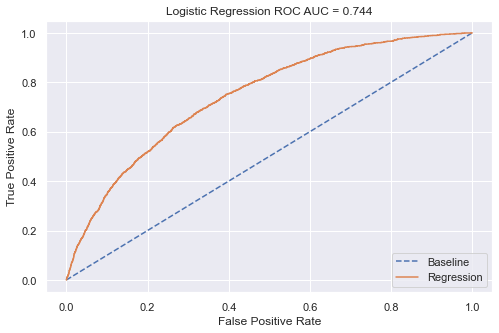

,Показатель,Значение
1,accuracy,0.6707
2,balanced_accuracy_score,0.6777
3,precision_score,0.2264
4,Sensitivity_recall_score,0.6869
5,Specificity_1-fpr,0.7144
6,f1,0.3406
7,fpr,0.2856
8,tpr,0.5401
9,roc_auc,0.7442
10,cohen_kappa_score,0.1897


Доля правильных ответов классификатора на обучающей выборке: 0.669
Матрица ошибок


,NoDefault-0,Default-1
NoDefault-0,8645,4288
Default-1,572,1255


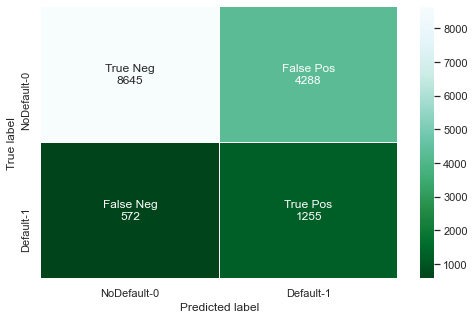

In [66]:
probs_0 = model_0.predict_proba(X_test)
probs_0 = probs_0[:, 1]
# probs_0 = np.where(probs_0 > 0.5, 1, 0) # установили порог, если вероятность больше 0,5 - дефолт

fpr, tpr, threshold = roc_curve(y_test, probs_0)
roc_auc = roc_auc_score(y_test, probs_0)
conf_mat_0 = confusion_matrix(y_test, y_pred_0)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

metrics_0 = {'accuracy': round(accuracy_score(y_test, y_pred_0), 4),
             'balanced_accuracy_score': round(balanced_accuracy_score(y_test, y_pred_0), 4),
             'precision_score': round(precision_score(y_test, y_pred_0), 4),
             'Sensitivity_recall_score': round(recall_score(y_test, y_pred_0), 4),
             'Specificity_1-fpr': round(1 - fpr.mean(), 4),
             'f1': round(f1_score(y_test, y_pred_0), 4),
             'fpr': round(fpr.mean(), 4),
             'tpr': round(tpr.mean(), 4),
             'roc_auc': round(roc_auc, 4),
             'cohen_kappa_score': round(cohen_kappa_score(y_test, y_pred_0), 4)}
display(pd.DataFrame(metrics_0.items(), columns=[
        'Показатель', 'Значение'], index=range(1, 11)))
print(
    f'Доля правильных ответов классификатора на обучающей выборке: {round(model_0.score(X_train, y_train),3)}')
#coef = np.exp(model.coef_[0])
# print(coef)
class_names = ['NoDefault-0', 'Default-1']
df_cm = pd.DataFrame(conf_mat_0, index=class_names, columns=class_names)
print(f'Матрица ошибок')
display(df_cm)
plt.figure(figsize=(8, 5))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_0).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(df_cm, annot=labels, fmt='', cmap='BuGn_r', linewidths=0.01)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Валидация на hold-out выборке

In [67]:
X_tr, X_valid, y_tr, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
print(X_train.shape, X_tr.shape, X_valid.shape,
      y_train.shape, y_tr.shape, y_valid.shape)

(59039, 40) (41327, 40) (17712, 40) (59039,) (41327,) (17712,)


In [68]:
logres = LogisticRegression(
    class_weight='balanced', max_iter=2000, random_state=RANDOM_SEED).fit(X_tr, y_tr)
logres.fit(X_tr, y_tr)
y_pred_tr = logres.predict(X_tr)
f1_train = f1_score(y_tr, y_pred_tr)
print(f'[train] F1-score = {f1_train:.2f}')

y_pred = logres.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
print(f'[valid] F1-score = {f1_val:.2f}')

[train] F1-score = 0.34
[valid] F1-score = 0.34


#### Кросс-валидация

{'fit_time': array([0.90105152, 0.85904932, 0.75204301, 0.83504796, 0.79204535]), 'score_time': array([0.00700045, 0.00800061, 0.00700021, 0.00700021, 0.00700021]), 'test_score': array([0.6714939 , 0.66327913, 0.66912263, 0.66666667, 0.67315999]), 'train_score': array([0.66894624, 0.67076708, 0.66898859, 0.67044949, 0.66884739])}
[train] F1-score = 0.67 +/- 0.00
[valid] F1-score = 0.67 +/- 0.00


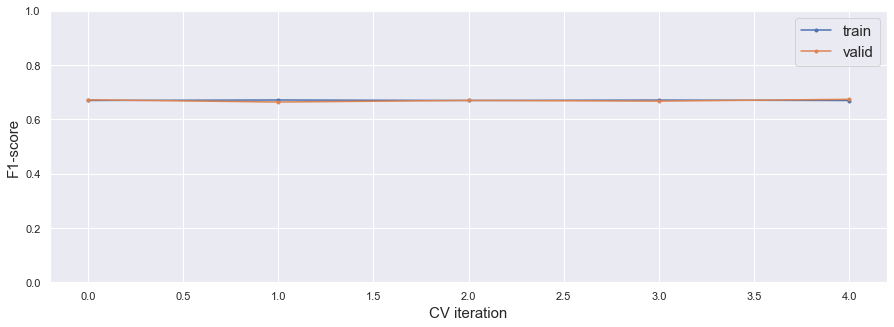

In [69]:
logres = LogisticRegression(class_weight='balanced',
                            max_iter=2000, random_state=RANDOM_SEED)
cv_metrics = cross_validate(
    logres, X_train, y_train, cv=5, scoring='f1_micro', return_train_score=True)
print(cv_metrics)


def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(
    ), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(
    ), cv_metrics['test_score'].std()
    print(
        '[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print(
        '[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))

    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.])
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)


plot_cv_metrics(cv_metrics)

***Выводы:*** Показатели модели приемлемые, переобучение не обнаружено

#### Модель версия 1. Базовая + oversampling

### Масштабирование

In [70]:
os = SMOTE(random_state=RANDOM_SEED)
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
print(sorted(Counter(os_data_y).items()))
os_data_y1 = pd.DataFrame(data=os_data_y, columns=['default'])
# Мы можем проверить числа наших данных
print("Длина данных с передискретизацией ", len(os_data_X))
print("Количество Недефолтов в данных с избыточной выборкой ",
      len(os_data_y1[os_data_y1['default'] == 0]))
print("Количество дефолтов в данных с избыточной выборкой ",
      len(os_data_y1[os_data_y1['default'] == 1]))
print("Доля Недефолтов в данных с избыточной выборкой составляет ",
      len(os_data_y1[os_data_y1['default'] == 0])/len(os_data_X))
print("Доля Недефолтов в данных с избыточной выборкой составляет ",
      len(os_data_y1[os_data_y1['default'] == 1])/len(os_data_X))

[(0, 51494), (1, 51494)]
Длина данных с передискретизацией  102988
Количество Недефолтов в данных с избыточной выборкой  51494
Количество дефолтов в данных с избыточной выборкой  51494
Доля Недефолтов в данных с избыточной выборкой составляет  0.5
Доля Недефолтов в данных с избыточной выборкой составляет  0.5


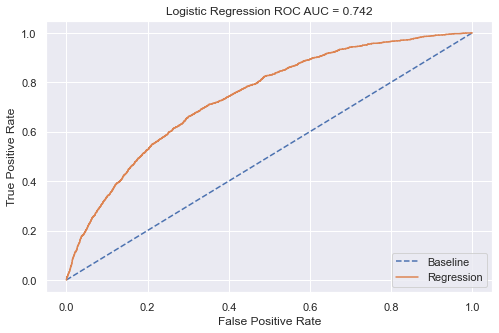

,Показатель,Значение
1,accuracy,0.6758
2,balanced_accuracy_score,0.6785
3,precision_score,0.2286
4,Sensitivity_recall_score,0.6820
5,Specificity_1-fpr,0.7112
6,f1,0.3424
7,fpr,0.2888
8,tpr,0.5411
9,roc_auc,0.7417
10,cohen_kappa_score,0.1928


Доля правильных ответов классификатора на обучающей выборке: 0.672
Матрица ошибок


,NoDefault-0,Default-1
NoDefault-0,8729,4204
Default-1,581,1246


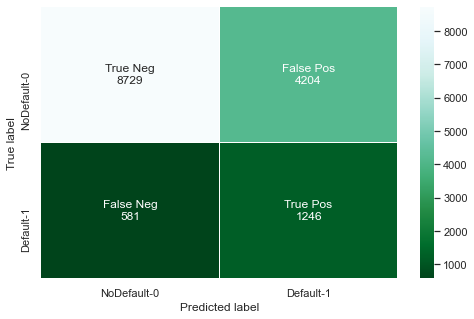

In [71]:
# обучим модель
# penalty='l2', solver='liblinear', C=0.001, class_weight='balanced', max_iter=1000
model_1 = LogisticRegression(
    max_iter=2000, random_state=RANDOM_SEED).fit(os_data_X, os_data_y)
y_pred_1 = model_1.predict(X_test)
probs_1 = model_1.predict_proba(X_test)
probs_1 = probs_1[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs_1)
roc_auc = roc_auc_score(y_test, probs_1)
conf_mat_1 = confusion_matrix(y_test, y_pred_1)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

metrics_1 = {'accuracy': round(accuracy_score(y_test, y_pred_1), 4),
             'balanced_accuracy_score': round(balanced_accuracy_score(y_test, y_pred_1), 4),
             'precision_score': round(precision_score(y_test, y_pred_1), 4),
             'Sensitivity_recall_score': round(recall_score(y_test, y_pred_1), 4),
             'Specificity_1-fpr': round(1 - fpr.mean(), 4),
             'f1': round(f1_score(y_test, y_pred_1), 4),
             'fpr': round(fpr.mean(), 4),
             'tpr': round(tpr.mean(), 4),
             'roc_auc': round(roc_auc, 4),
             'cohen_kappa_score': round(cohen_kappa_score(y_test, y_pred_1), 4)}
display(pd.DataFrame(metrics_1.items(), columns=[
        'Показатель', 'Значение'], index=range(1, 11)))
print(
    f'Доля правильных ответов классификатора на обучающей выборке: {round(model_1.score(X_train, y_train),3)}')

class_names = ['NoDefault-0', 'Default-1']
df_cm = pd.DataFrame(conf_mat_1, index=class_names, columns=class_names)
print(f'Матрица ошибок')
display(df_cm)
plt.figure(figsize=(8, 5))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_1).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(df_cm, annot=labels, fmt='', cmap='BuGn_r', linewidths=0.01)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Валидация на hold-out выборке

In [72]:
X_tr, X_valid, y_tr, y_valid = train_test_split(
    os_data_X, os_data_y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
print(X_train.shape, X_tr.shape, X_valid.shape,
      y_train.shape, y_tr.shape, y_valid.shape)

(59039, 40) (72091, 40) (30897, 40) (59039,) (72091,) (30897,)


In [73]:
logres = LogisticRegression(
    max_iter=2000, random_state=RANDOM_SEED).fit(X_tr, y_tr)
logres.fit(X_tr, y_tr)
y_pred_tr = logres.predict(X_tr)
f1_train = f1_score(y_tr, y_pred_tr)
print(f'[train] F1-score = {f1_train:.2f}')

y_pred = logres.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
print(f'[valid] F1-score = {f1_val:.2f}')

[train] F1-score = 0.69
[valid] F1-score = 0.68


#### Кросс-валидация

{'fit_time': array([2.63315058, 2.17012405, 2.07411861, 1.41108084, 1.55308867]), 'score_time': array([0.05200291, 0.01100087, 0.01100087, 0.01100063, 0.01100087]), 'test_score': array([0.67258957, 0.68118264, 0.69210603, 0.68393455, 0.6898092 ]), 'train_score': array([0.68749848, 0.68482826, 0.68277704, 0.684383  , 0.68312073])}
[train] F1-score = 0.68 +/- 0.00
[valid] F1-score = 0.68 +/- 0.01


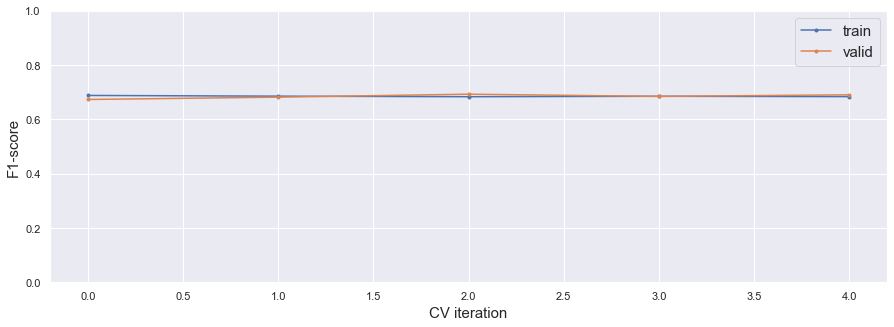

In [74]:
logres = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
cv_metrics = cross_validate(
    logres, os_data_X, os_data_y, cv=5, scoring='f1_micro', return_train_score=True)
print(cv_metrics)


def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(
    ), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(
    ), cv_metrics['test_score'].std()
    print(
        '[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print(
        '[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))

    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.])
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)


plot_cv_metrics(cv_metrics)

***Выводы:*** метрика f1 при данном масштабировании увеличилась с 0,3406 до 0,3424; метрика roc_auc снизилась с 0,7442 до 0,7417. На мой взгляд модель стала хуже работать, т.к. стала считать больше недефолтных клиентов, которым можно безопасно предложить кредит.

#### Модель версия 2. Базовая  + настройка гиперпараметров

Попробуем улучшить модель подбором гиперпараметров

In [75]:
# Подбор лучших гиперпараметров для модели
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Добавим типы решателей
solver = ['liblinear', 'lbfgs']

# Зададим ограничения для параметра регуляризации
C = np.logspace(-2, 4, 100)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

#model = LogisticRegression(solver = 'liblinear', max_iter = 2000)
model = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
# model.fit(os_data_X,os_data_y)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)
print(best_model.best_estimator_.get_params())
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее solver:', best_model.best_estimator_.get_params()['solver'])
C = best_model.best_estimator_.get_params()['C']

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Лучшее Penalty: l2
Лучшее C: 1.0
Лучшее solver: lbfgs


In [76]:
C

1.0

#### Обучаем модель с лучшими гиперпараметрами:

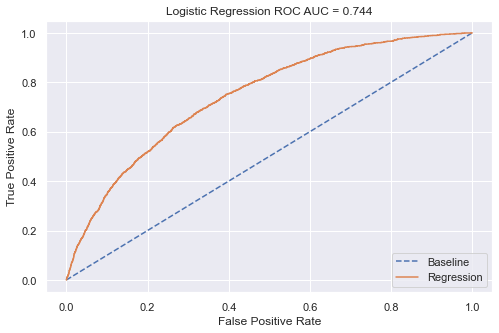

,Показатель,Значение
1,accuracy,0.6707
2,balanced_accuracy_score,0.6777
3,precision_score,0.2264
4,Sensitivity_recall_score,0.6869
5,Specificity_1-fpr,0.7144
6,f1,0.3406
7,fpr,0.2856
8,tpr,0.5401
9,roc_auc,0.7442
10,cohen_kappa_score,0.1897


Доля правильных ответов классификатора на обучающей выборке: 0.669
Матрица ошибок


,NoDefault-0,Default-1
NoDefault-0,8645,4288
Default-1,572,1255


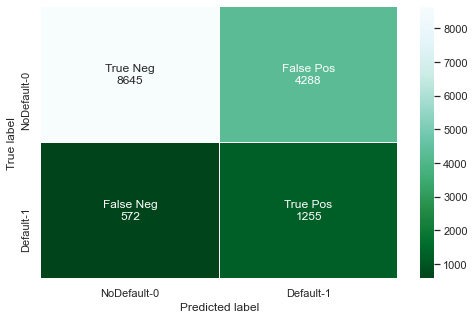

In [84]:
# обучим модель
model_2 = LogisticRegression(penalty='l2', C=C, solver='lbfgs',
                             class_weight='balanced', max_iter=2000, random_state=RANDOM_SEED)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
probs_2 = model_2.predict_proba(X_test)
probs_2 = probs_2[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs_2)
roc_auc = roc_auc_score(y_test, probs_2)
conf_mat_2 = confusion_matrix(y_test, y_pred_2)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

metrics_2 = {'accuracy': round(accuracy_score(y_test, y_pred_2), 4),
             'balanced_accuracy_score': round(balanced_accuracy_score(y_test, y_pred_2), 4),
             'precision_score': round(precision_score(y_test, y_pred_2), 4),
             'Sensitivity_recall_score': round(recall_score(y_test, y_pred_2), 4),
             'Specificity_1-fpr': round(1 - fpr.mean(), 4),
             'f1': round(f1_score(y_test, y_pred_2), 4),
             'fpr': round(fpr.mean(), 4),
             'tpr': round(tpr.mean(), 4),
             'roc_auc': round(roc_auc, 4),
             'cohen_kappa_score': round(cohen_kappa_score(y_test, y_pred_2), 4)}
display(pd.DataFrame(metrics_2.items(), columns=[
        'Показатель', 'Значение'], index=range(1, 11)))
print(
    f'Доля правильных ответов классификатора на обучающей выборке: {round(model_2.score(X_train, y_train),3)}')

class_names = ['NoDefault-0', 'Default-1']
df_cm = pd.DataFrame(conf_mat_2, index=class_names, columns=class_names)
print(f'Матрица ошибок')
display(df_cm)
plt.figure(figsize=(8, 5))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred_2).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(df_cm, annot=labels, fmt='', cmap='BuGn_r', linewidths=0.01)
plt.ylabel('True label')
plt.xlabel('Predicted label')

***Выводы:*** Модель с подобранными гиперпараметрами C=1.0, penalty=L2 и solver=lbfgs не улучшила базовую модель. Возможно гиперпараметры некорректно подобраны.

In [85]:
metrics = {'metrics_0': metrics_0,
           'metrics_1': metrics_1,\
           'metrics_2': metrics_2}
pd.DataFrame(metrics)

,metrics_0,metrics_1,metrics_2
accuracy,0.6707,0.6758,0.6707
balanced_accuracy_score,0.6777,0.6785,0.6777
precision_score,0.2264,0.2286,0.2264
Sensitivity_recall_score,0.6869,0.6820,0.6869
Specificity_1-fpr,0.7144,0.7112,0.7144
f1,0.3406,0.3424,0.3406
fpr,0.2856,0.2888,0.2856
tpr,0.5401,0.5411,0.5401
roc_auc,0.7442,0.7417,0.7442
cohen_kappa_score,0.1897,0.1928,0.1897


In [86]:
conf_mat = {'conf_mat_0': [conf_mat_0],\
            'conf_mat_1': [conf_mat_1],\
            'conf_mat_2': [conf_mat_2]}
pd.DataFrame(conf_mat)

,conf_mat_0,conf_mat_1,conf_mat_2
0,"[[8645, 4288], [572, 1255]]","[[8729, 4204], [581, 1246]]","[[8645, 4288], [572, 1255]]"


# 7. Submission

In [87]:
sample_submission.tail(3)

,client_id,default
24351,74542,0.830871
24352,82350,0.371539
24353,27866,0.271120


In [88]:
X.shape

(73799, 40)

In [89]:
X_test_data.shape

(36349, 40)

In [90]:
y_probs = model_0.predict_proba(X_test_data)[:, 1]

test['default'] = y_probs
submission = test[['client_id', 'default']]
display(submission.sample(10))
display(submission.shape)

submission.to_csv('submission.csv', index=False)

,client_id,default
28857,103837,0.753553
23183,7653,0.158849
28245,23735,0.554612
31194,1569,0.472278
7330,72508,0.726243
27177,89806,0.217476
19665,78547,0.599705
4507,22599,0.395354
15447,93931,0.456938
30791,47396,0.119972


(36349, 2)

## Выводы

После обработки датасета и добавления новых признаков была сгенерирована базовая модель логистической регрессии, которая показала ROC AUC > 0.74, а также accuracy 0.67, precision 0.226, recall 0.687 и f1_score 0.34.

Была выбрана базовая модель, т.к. она показала лучший результат. Данную модель не смогла донастроить подбором параметров через SearchCV. Ошибка II рода остается высокой.